Let us first import all the packages we need for analysis.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import geopandas as gpd
import matplotlib.cm as cm
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 
from IPython.core.display import HTML 
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import geopy
## for machine learning
from sklearn import preprocessing, cluster
import scipy
print("All packages imported!")

All packages imported!


Alright, now let us import the raw dataset for student preferences...

In [ ]:
dfstudents=pd.read_csv(r'C:\Users\priya\OneDrive\Documents\Geolocational_Data_Analysis_Final\Location_Clustering-master\food_coded.csv')

We shall only take the columns useful to us:

In [ ]:
dfclean=dfstudents[['cook','eating_out','employment','ethnic_food','exercise','fruit_day','income','on_off_campus','pay_meal_out','sports','veggies_day']]
dfclean.dropna(axis=0,inplace=True)
dfclean.head()

,cook,eating_out,employment,ethnic_food,exercise,fruit_day,income,on_off_campus,pay_meal_out,sports,veggies_day
0,2.0,3,3.0,1,1.0,5,5.0,1.0,2,1.0,5
1,3.0,2,2.0,4,1.0,4,4.0,1.0,4,1.0,4
2,1.0,2,3.0,5,2.0,5,6.0,2.0,3,2.0,5
3,2.0,2,3.0,5,3.0,4,6.0,1.0,2,2.0,3
4,1.0,2,2.0,4,1.0,4,6.0,1.0,4,1.0,4


Let us visualise the distrubtion of data with a boxplot:

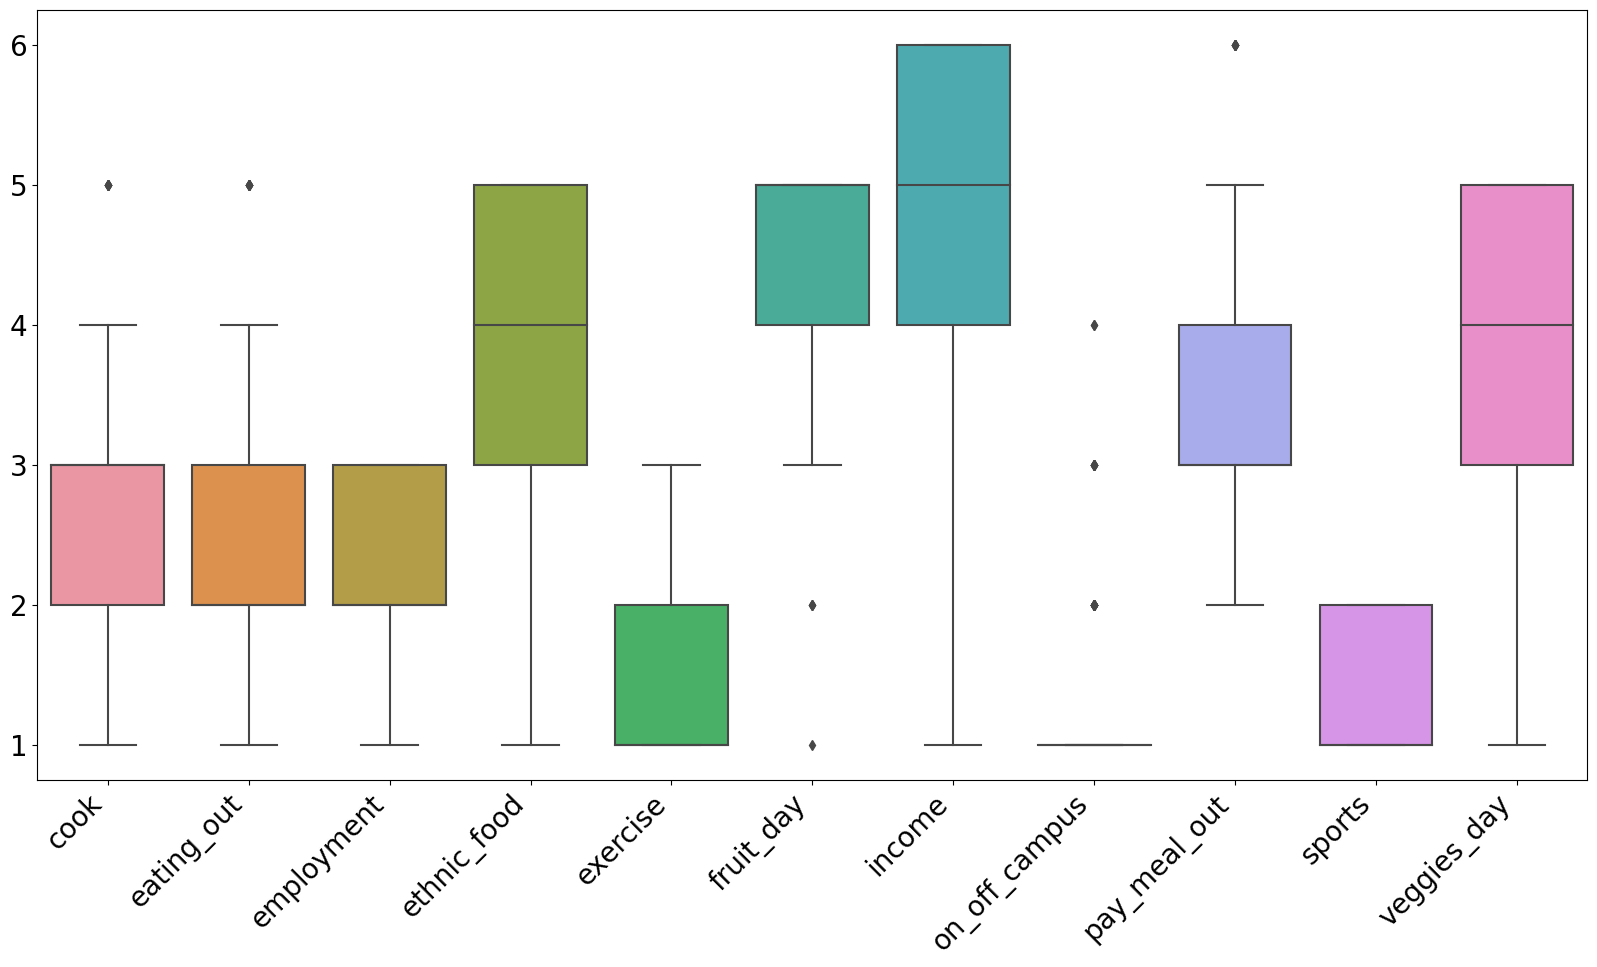

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = dfclean)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

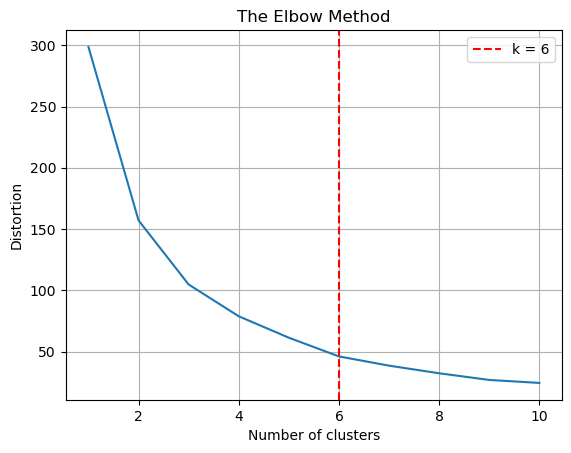

In [ ]:
f=['cook','income']
s=dfclean.dropna()
X = s[f]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfclean)
dfclean['Cluster']=kmeans.labels_

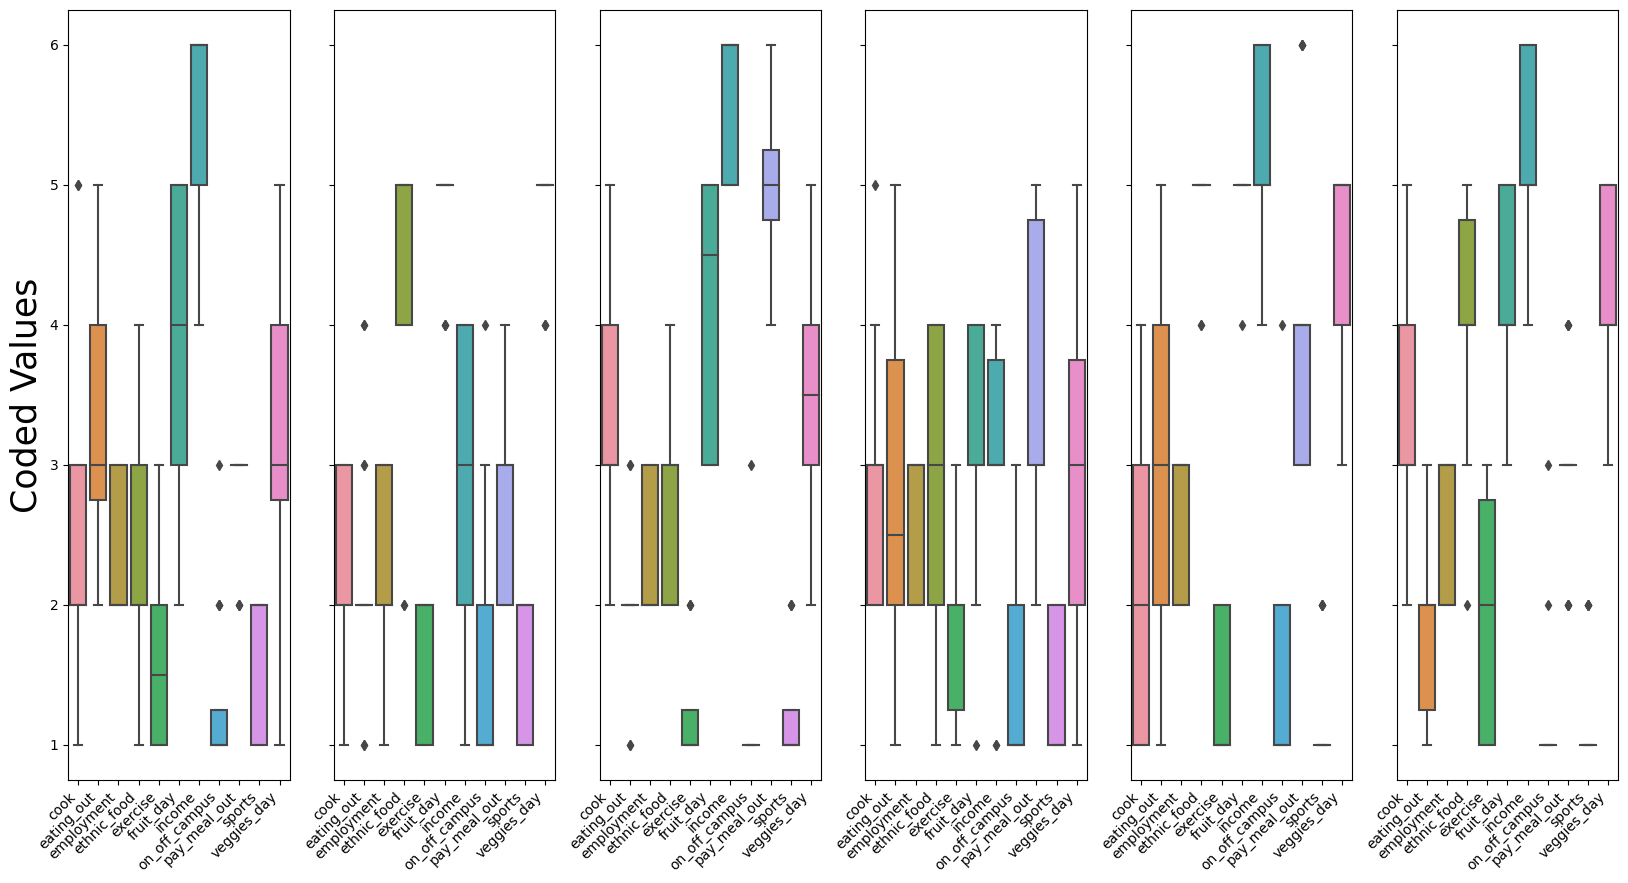

In [ ]:
fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)
axes[0].set_ylabel('Coded Values', fontsize=25)

for k in range(kclusters):
     plt.sca(axes[k])
     plt.xticks(rotation=45,ha='right')
     sns.boxplot(data = dfclean[dfclean['Cluster'] == k].drop('Cluster',1), ax=axes[k])
        
plt.show()

In [ ]:
search_query = 'Apartment' #Search for residential locations
radius = 18000 #Set the radius to 18 kilometres due to traffic constraints
latitude=12.944172#College location
longitude=77.5091486

Now to define our foursquare credentials:

In [ ]:
CLIENT_ID = '5O2OQN1HOFBER5CQ4VJSEBU3PZ54Z3T31EGTNFJ0V04KSKZI'
CLIENT_SECRET = 'H2KIZ3QZRGZD2GVCOSSTL04SQ3N0Y5QWEWQKPQ1VTPQNF24R' 
VERSION = '20180604'
LIMIT = 200

Now to define the url:

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

Now, we pull the results of the query into a json file.

In [ ]:
results = requests.get(url).json()

In [ ]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

Some categories don't mean much to us, such as ID and referralID. Let's only take the fields relevant to us:

In [ ]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
d=dataframe_filtered.drop([4,17,18,21,24,30,43],axis=0,inplace=True) #remove some unwanted locations like hotels
dataframe_filtered.drop(['cc','country','state','city'],axis=1,inplace=True) #no need for those columns as we know we're in Bangalore,IN
dataframe_filtered.head()

Let us plot all these potential locations on a map of Bangalore:

In [ ]:
#define coordinates of the college
map_bang=folium.Map(location=[12.971599,77.594566],zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()

latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
labels = list(dataframe_filtered.name)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_bang)    
    
# add incidents to map
map_bang.add_child(locations)

# add incidents to map
map_bang.add_child(locations)

map_bang

Now, let's figure out which locations are ideal for which kinds of student. 

We will keep in mind the fact that the lower income students need a steady supply of fresh fruits, while the high income students need plenty of restaurant options to choose from.

In [ ]:
df_evaluate=dataframe_filtered[['lat','lng']]

In [ ]:
RestList=[]
latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
for lat, lng in zip(latitudes, longitudes):    
    radius = 5000 #Set the radius to 5 kilometres for convenience
    latitude=lat#Query for the apartment location in question
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    search_query = 'Restaurant' #Search for any food related locations
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe2 = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
    dataframe_filtered2 = dataframe2.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
    RestList.append(dataframe_filtered2['categories'].count())


In [ ]:
df_evaluate['Restaurants']=RestList

In [ ]:
FruitList=[]
latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
for lat, lng in zip(latitudes, longitudes):    
    radius = 5000 #Set the radius to 5 kilometres for convenience
    latitude=lat#Query for the apartment location in question
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    search_query = 'Fruit' #Search for any food related locations
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe2 = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
    dataframe_filtered2 = dataframe2.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
    FruitList.append(dataframe_filtered2['categories'].count())


In [ ]:
df_evaluate['Fruits,Vegetables,Groceries']=FruitList

In [ ]:
GymList=[]
latitudes = list(dataframe_filtered.lat)
longitudes = list( dataframe_filtered.lng)
for lat, lng in zip(latitudes, longitudes):    
    radius = 5000 #Set the radius to 5 kilometres for convenience
    latitude=lat#Query for the apartment location in question
    longitude=lng
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    search_query = 'Gym' #Search for any food related locations
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe2 = json_normalize(venues)
    filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
    dataframe_filtered2 = dataframe2.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
    GymList.append(dataframe_filtered2['categories'].count())

In [ ]:
df_evaluate['Gym']=GymList

In [ ]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_evaluate)
df_evaluate['Cluster']=kmeans.labels_
df_evaluate['Cluster']=df_evaluate['Cluster'].apply(str)
df_evaluate.head(10)

In [ ]:
#define coordinates of the college
map_bang=folium.Map(location=[12.971599,77.594566],zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
locations = folium.map.FeatureGroup()
# set color scheme for the clusters
def color_producer(cluster):
    if cluster=='0':
        return 'green'
    elif cluster=='1':
        return 'orange'
    else:
        return 'red'
latitudes = list(df_evaluate.lat)
longitudes = list(df_evaluate.lng)
labels = list(df_evaluate.Cluster)
names=list(dataframe_filtered.name)
for lat, lng, label,names in zip(latitudes, longitudes, labels,names):
    folium.CircleMarker(
            [lat,lng],
            fill=True,
            fill_opacity=1,
            popup=folium.Popup(names, max_width = 300),
            radius=5,
            color=color_producer(label)
        ).add_to(map_bang)

# add locations to map
map_bang.add_child(locations)

map_bang

    

Applying K-Means, we find 3 prominent clusters:

Cluster 0(Green) Where  (fruits and vegetables) (gym) and (restaurants) are abundant

Cluster 1(Yellow): Restaurants and Gym are plentiful, but groceries less so.

Cluster 2(Red): Gym and groceries are relatively hard to find.